#### $step1.$导包

In [53]:
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import random
from copy import deepcopy as dcp
import heapq 

---
#### $step2.$导入数据

In [54]:
Train = pd.read_csv('/kaggle/input/ml-100k/u.dataTrain', header = None, sep = '\t')
print(Train)
train = Train.values

         0    1  2          3
0        0  167  5  874965478
1        0  171  5  874965478
2        0  164  5  874965518
3        0  155  4  874965556
4        0  195  5  874965677
...    ...  ... ..        ...
80362  942  414  1  888640027
80363  942  719  1  888640048
80364  942   79  2  888640048
80365  942   52  3  888640067
80366  942  216  3  888640067

[80367 rows x 4 columns]


In [55]:
Test = pd.read_csv('/kaggle/input/ml-100k/u.dataTest', header = None, sep = '\t')
print(Test)
test = Test.values

         0    1  2          3
0        0  200  3  878542960
1        0  207  5  878542960
2        0  115  3  878542960
3        0   57  4  878542960
4        0    2  4  878542960
...    ...  ... ..        ...
19544  942  448  1  888693158
19545  942  228  2  888693158
19546  942  229  1  888693158
19547  942  227  3  888693158
19548  942  233  3  888693184

[19549 rows x 4 columns]


In [56]:
Matrix = pd.read_csv('/kaggle/input/ml-100k/u.dataTrainmat', header = None, sep = '\t')
print(Matrix)
matrix = Matrix.values

     0     1     2     3     4     5     6     7     8     9     ...  1671  \
0     5.0   3.0   0.0   3.0   0.0   0.0   4.0   1.0   0.0   3.0  ...   0.0   
1     4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0  ...   0.0   
2     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4     4.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
938   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   5.0   0.0  ...   0.0   
939   0.0   0.0   0.0   0.0   0.0   0.0   4.0   5.0   3.0   0.0  ...   0.0   
940   0.0   0.0   0.0   0.0   0.0   0.0   4.0   0.0   0.0   0.0  ...   0.0   
941   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
942   0.0   5.0   0.0   0.0   0.0   0.0   0.0   0.0   3.0   0.0  ...   0.0   

     1672  1673  1674  1675  1676  1677  1678  1679  1680  
0  

---
#### $step3.$ KNN

In [57]:
class _KNN():
    # written by pipedream
    # matrix_version
    def __init__(self):
        self.has_cos = False
        self.has_predict_matrix = False
        self.kvalue_top_k = -1
        self.MAE = -1
        self.RMSD = -1
        self.cos = []
        self.topk = []
        self.matrix = []
        self.avg_ru = []
        self.predict_matrix = []
        
    def CosineSimilar(self, _ratings):
        for i in tqdm(range(1)):
            ratings = np.array(_ratings)
            H = ratings.copy()
            R = ratings.copy()
            H[H > 0] = 1

            up = np.dot(R, R.T)
            norm1 = np.dot(np.multiply(R, R), H.T)
            norm2 = np.dot(H, np.multiply(R, R).T)
            down = np.sqrt(np.multiply(norm1, norm2))
            down[down == 0] = 1

            sim = up / down
            np.fill_diagonal(sim, 0)
        return sim

    # input matrix: persons-items
    def fit(self, _matrix, KNN_k):
        
        matrix = dcp(np.array(_matrix))
        person_count = len(matrix)
        item_count = len(matrix[0])
        diff = 0
        
        #---- cal cos_matrix ----
        if self.has_cos == False or self.matrix.all() != matrix.all():
            
            avg_ru = []
            for i in range(person_count):
                u, d = 0, 0
                for j in range(item_count):
                    if matrix[i][j] != 0:
                        u += matrix[i][j]
                        d += 1
                avg_ru.append(u / d if d != 0 else 0)
            
            self.has_cos = True
            self.avg_ru = dcp(avg_ru)
            self.matrix = dcp(matrix)
            self.cos = dcp(self.CosineSimilar(matrix))
            
            topk = [] # person -> topk_neighbours : [[cos, idx], [cos, idx]]
            
            for i in tqdm(range(person_count)):
                def cal(x):
                    return self.cos[i][x]
                per_topk = [tk for tk in range(person_count) if self.cos[i][tk] > 0]
                per_topk.sort(key = cal)
                topk.append(per_topk)

        
            self.topk = dcp(topk)
            diff += 1

    
        #---- cal predict_matrix ----
        if self.has_predict_matrix == False or self.kvalue_top_k != KNN_k or diff > 0:

            self.predict_matrix = dcp(matrix)
            self.predict_matrix = self.predict_matrix.astype(float)
            
            pos = np.where(matrix == 0)
            x, y = pos[0], pos[1]
            for idx in tqdm(range(len(x))):
                i, j, up, dw, cnt = x[idx], y[idx], 0, 0, 0
                for k in self.topk[i]:
                    if matrix[k][j] == 0: 
                        continue
                    cnt += 1
                    up += (matrix[k][j] - self.avg_ru[k]) * self.cos[i][k]
                    dw += self.cos[i][k]
                    if cnt >= KNN_k:
                        break
                            
                self.predict_matrix[i][j] = self.avg_ru[i] + ((up / dw) if dw != 0 else random.uniform(0, 5))

            self.has_predict_matrix = True
            self.kvalue_top_k = KNN_k

    
    def predict(self, Test):
        
        _MAE = 0
        _RMSD = 0
        test_person_count = len(test)
        for data in Test:
            person, item, rating, ti = data
            _MAE += abs(self.predict_matrix[person][item] - rating)
            _RMSD += (self.predict_matrix[person][item] - rating) * (self.predict_matrix[person][item] - rating)
            
        self.MAE = _MAE / test_person_count
        self.RMSD = np.sqrt(_RMSD / test_person_count)
    
    def score(self):
        
        if self.MAE == -1:
            print('No-Test-Perdict')
        else:
            print('MAE: ', self.MAE)
            print('RMSD: ', self.RMSD)

In [58]:
knn = _KNN()
knn.fit(matrix, 2)

100%|██████████| 1504816/1504816 [03:03<00:00, 8182.13it/s] 


In [59]:
knn.predict(test)
knn.score()

MAE:  1.1145303710922603
RMSD:  1.3955974255720653


In [60]:
knn.fit(matrix, 3)
knn.predict(test)
knn.score()

100%|██████████| 1504816/1504816 [03:58<00:00, 6304.69it/s]


MAE:  1.0220422704246441
RMSD:  1.2809618983482334


In [61]:
knn.fit(matrix, 5)
knn.predict(test)
knn.score()

100%|██████████| 1504816/1504816 [05:07<00:00, 4899.54it/s]


MAE:  0.9455281700756469
RMSD:  1.187782673614962


In [62]:
knn.fit(matrix, 10)
knn.predict(test)
knn.score()

100%|██████████| 1504816/1504816 [06:46<00:00, 3704.85it/s]

MAE:  0.8845006542160077
RMSD:  1.1101178544389145


In [63]:
knn.fit(matrix, 20)
knn.predict(test)
knn.score()

100%|██████████| 1504816/1504816 [08:22<00:00, 2992.12it/s]

MAE:  0.8475480016405725
RMSD:  1.0648317653016772


In [67]:
knn.fit(matrix, 50)
knn.predict(test)
knn.score()

100%|██████████| 1504816/1504816 [10:30<00:00, 2387.27it/s]


MAE:  0.8199112972964715
RMSD:  1.0327111317896167


In [68]:
knn.fit(matrix, 100)
knn.predict(test)
knn.score()

100%|██████████| 1504816/1504816 [11:40<00:00, 2147.54it/s]


MAE:  0.808407922051376
RMSD:  1.0183095800451012


In [71]:
import matplotlib.pyplot as plt
x = [2, 3, 5, 10, 20, 50, 100]
y_MAE = [1.1145303710922603, 1.0220422704246441, 0.9455281700756469, 0.8845006542160077, 0.8475480016405725, 0.8199112972964715, 0.808407922051376]
y_RMSD = [1.3955974255720653, 1.2809618983482334, 1.187782673614962, 1.1101178544389145, 1.0648317653016772, 1.0327111317896167, 1.0183095800451012]
y_predict_time = [183, 238, 307, 406, 502, 630, 700]

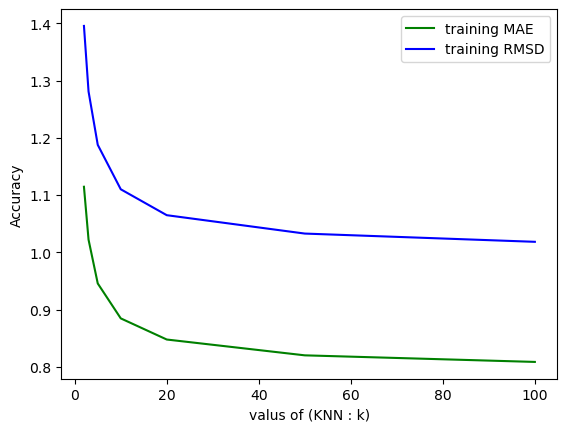

In [72]:
plt.plot(x, y_MAE, color='green', label='training MAE')
plt.plot(x, y_RMSD, color='blue', label='training RMSD')
plt.legend()
plt.xlabel('valus of (KNN : k)')
plt.ylabel('Accuracy')
plt.show()

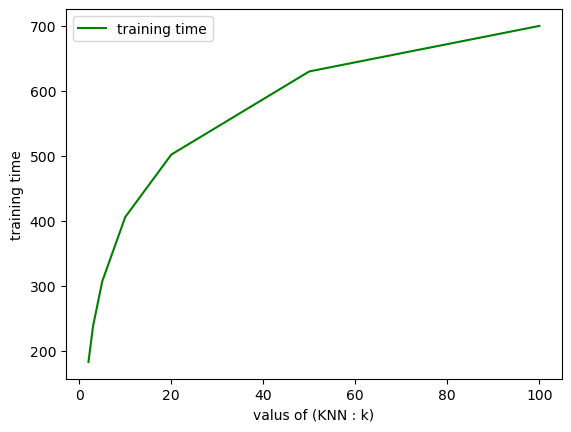

In [73]:
plt.plot(x, y_predict_time, color='green', label='training time')
plt.legend()
plt.xlabel('valus of (KNN : k)')
plt.ylabel('training time')
plt.show()